In [193]:
import pandas as pd
import os
from itertools import permutations

import warnings
warnings.filterwarnings('ignore')

data_dir = 'C:/Users/harry/Documents/data/Project_Node'
report_dir = 'C:/Users/harry/Documents/data/Project_Node/report/'

In [7]:
PeopleCalls = pd.read_csv(os.path.join(data_dir, 'CallParticipants.csv'))
person = pd.read_csv(os.path.join(data_dir, 'PersonHistorical.csv'))
Calls = pd.read_csv(os.path.join(data_dir, 'Calls.csv'))

C:\Users\Harry\AppData\Local\Temp\ipykernel_21124\2264513328.py:2: DtypeWarning: Columns (5,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  person = pd.read_csv(os.path.join(data_dir, 'PersonHistorical.csv'))


In [176]:
Calls['TotalParticipants'].max()

55

In [119]:
# Filter Person ID by Internal Netherland Office people 
filtered_person_df = person[(person['Country']=='Netherlands') & \
                                   ((person['Domain']=='CUSHWAKE.COM'))]

# Filter Call ID by meeting group size
filtered_calls = Calls[(Calls['TotalParticipants']>2) & ((Calls['TotalParticipants']<6))]


# People call filters by person id and call id
filtered_peoplecalls = PeopleCalls[(PeopleCalls['CallRecordId'].isin(filtered_calls['CallRecordId'])) &
                                   (PeopleCalls['PersonHistoricalId'].isin(filtered_person_df['PersonHistoricalId']))]

# filter People-call by Time Interval 
start_date = pd.to_datetime('2021-03-01')
end_date =  start_date + pd.offsets.MonthBegin(3)
filtered_peoplecalls['LocalStartTime'] = pd.to_datetime(filtered_peoplecalls['LocalStartTime'])
filtered_peoplecalls = filtered_peoplecalls[(filtered_peoplecalls['LocalStartTime'] > start_date) & 
(filtered_peoplecalls['LocalStartTime'] < end_date)]

# filter by duplicated call ids
filtered_peoplecalls = filtered_peoplecalls[filtered_peoplecalls.duplicated(subset='CallRecordId', keep=False)]

In [175]:
pair_call_df = pd.DataFrame()

for call_id in filtered_peoplecalls['CallRecordId'].unique():
    person_id_list = list(filtered_peoplecalls[filtered_peoplecalls['CallRecordId']==call_id]['PersonHistoricalId'])
    
    temp_df = pd.DataFrame(list(permutations(person_id_list, 2)))
    temp_df.columns = ['PersonId_A', 'PersonId_B']
    temp_df['CallRecordId'] = call_id
    pair_call_df = pd.concat([pair_call_df, temp_df])

In [178]:
pair_call_df = pair_call_df.merge(filtered_peoplecalls, on='CallRecordId', how='left')

In [185]:
pair_call_df.shape

(188810, 9)

In [182]:
duration_mins_df = pair_call_df.groupby(by=['PersonId_A', 'PersonId_B']).sum().reset_index().sort_values(by='DurationMinutes', ascending=False)

In [186]:
duration_mins_df.drop(['IsOrganizer'], axis=1, inplace=True)

In [194]:
duration_mins_df.to_csv(os.path.join(report_dir, 'Calls_Processed.csv'), index=False)

<AxesSubplot:>

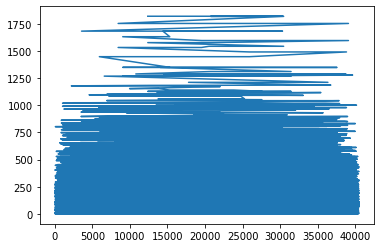

In [189]:
pd.set_option("display.max_rows", False, "display.max_columns", None)
duration_mins_df['DurationMinutes'].plot()

In [188]:
duration_mins_df.describe()

,DurationMinutes
count,40520.000000
mean,175.784773
std,150.590052
min,0.086997
25%,79.778322
50%,136.062378
75%,227.384718
max,1820.484444
